In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')

# SEED


### Backprop algo

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

    
class Network(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        np.random.seed(42)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        
        
    def feedforward(self, a):
        for layer, w, b in zip(range(self.num_layers),self.weights, self.biases):
            a = sigmoid(np.matmul(w, a) + b) 
        return a
    
    
    def train(self, training_data, epochs, mini_batch_size, eta, test_data):
        n_test = len(test_data)
        n = len(training_data)
        evaluates = []
        for j in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.gradient_descent(mini_batch, eta)
           

            # evaluate the model
            evaluate = self.evaluate(test_data)
            evaluates.append(evaluate)
            print(f'Epoch {j}: {evaluate} / {n_test}')
            

    
    def gradient_descent(self, mini_batch, eta):
        delJdelB = [np.zeros(b.shape) for b in self.biases]
        delJdelW = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_delJdelB, delta_delJdelW = self.backpropagation(x, y)
            delJdelB = [nb+dnb for nb, dnb in zip(delJdelB, delta_delJdelB)]
            delJdelW = [nw+dnw for nw, dnw in zip(delJdelW, delta_delJdelW)]
            
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, delJdelW)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, delJdelB)]
        
    
    def backpropagation(self, x, y):
        # initialize 
        delJdelB = [np.zeros(b.shape) for b in self.biases]
        delJdelW = [np.zeros(w.shape) for w in self.weights]
        
        
        activation = x
        activations = [x]
        z_vector = []
        for w, b in zip(self.weights, self.biases):
            z = np.matmul(w, activation) + b
            z_vector.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
            
        delta = sigmoid_prime(z_vector[-1]) * self.cost_derivative(activations[-1], y) 
        delJdelB[-1] = delta
        delJdelW[-1] = np.matmul(delta, activations[-2].T)
        
        
        for l in range(2, self.num_layers):
            z = z_vector[-l]
            sp = sigmoid_prime(z)
            delta = np.matmul(self.weights[-l+1].T, delta) * sp
            delJdelB[-l] = delta
            delJdelW[-l] = np.matmul(delta, activations[-l-1].T)
        return (delJdelB, delJdelW)
            
                                    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for x, y in test_data]
        return sum([int(x == y) for x, y in test_results])
    
    def cost_function(self, a, y):
        return np.sum(np.power((a - y), 2))
    
    
    def cost_derivative(self, activated_output, y):
        return 2 * (activated_output - y)

### CNN

In [3]:
class ConvNet:

    '''
    input : height, width, depth, stride, activation_function
    '''
    

    def __init__(self,out_depth, filter_dim, stride, padding) :
        self.out_depth = out_depth
        self.filter_dim = filter_dim
        self.stride = stride
        self.padding = padding
        np.random.seed(42)     
        self.first = True   

    def forward(self,input) :

        input_height, input_width, input_depth = input.shape
        output_height = int((input_height - self.filter_dim + 2 * self.padding) / self.stride + 1)
        output_width = int((input_width - self.filter_dim + 2 * self.padding) / self.stride + 1)
        
        output = np.zeros((output_height, output_width, self.out_depth))
        if self.first :
            self.filters = np.random.randn(self.filter_dim, self.filter_dim, input_depth, self.out_depth) / np.sqrt(self.filter_dim * self.filter_dim * input_depth)
            self.first = False
        # padding 
        input = np.pad(input, ((self.padding, self.padding), (self.padding, self.padding), (0,0)), 'constant')

        self.last_input = input

        for i in range(output_height):
            for j in range(output_width):
                for k in range(self.out_depth):
                    sum = 0
                    for id in range(input_depth) :
                        receptive_field = input[i*self.stride:i*self.stride+self.filter_dim, j*self.stride:j*self.stride+self.filter_dim, id]
                        sum += np.sum(receptive_field * self.filters[:,:,id,k])
                    output[i,j,k] = sum
        
        return output

    def backward(self,dL_dout,learning_rate):
        '''
            dL_dFilter = dOut_dFilter * dL_dOut
        '''

        dL_dFilter = np.zeros(self.filters.shape)
        output = self.last_input

        for i in range(dL_dout.shape[0]):
            for j in range(dL_dout.shape[1]):
                for k in range(dL_dout.shape[2]):
                    image_region = self.last_input[i*self.stride:i*self.stride+self.filter_dim, j*self.stride:j*self.stride+self.filter_dim, :]
                    dL_dFilter[:,:,:,k] += image_region * dL_dout[i,j,k]   
                    output[i*self.stride:i*self.stride+self.filter_dim, j*self.stride:j*self.stride+self.filter_dim, :] += self.filters[:,:,:,k] * dL_dout[i,j,k]   
        # update filters
        self.filters -= learning_rate*dL_dFilter
        
        return output


    



class MaxPool:

    def __init__(self,height,width):
        self.height = height
        self.width = width
    
    def forward(self,input):
        self.input = input
        output_height = int(self.input.shape[0] / self.height)
        output_width = int(self.input.shape[1] / self.width)

        output = np.zeros((output_height, output_width, self.input.shape[2]))

        for i in range(output_height):
            for j in range(output_width):
                for k in range(self.input.shape[2]):
                    output[i,j,k] = np.max(self.input[i*self.height:i*self.height+self.height, j*self.width:j*self.width+self.width, k])
        return output

    def backward(self,dL_dout,learning_rate):
        dL_din = np.zeros(self.input.shape)
        output_height = int(self.input.shape[0] / self.height)
        output_width = int(self.input.shape[1] / self.width)

        for i in range(output_height):
            for j in range(output_width):
                for k in range(self.input.shape[2]):
                    image_region = self.input[i*self.height:i*self.height+self.height, j*self.width:j*self.width+self.width, k]                    
                    max_value = np.max(image_region)
                    dL_din[i*self.height:i*self.height+self.height, j*self.width:j*self.width+self.width, k] += (image_region == max_value) * dL_dout[i,j,k]

                    

        return dL_din



class FC:
    
    # fully connected layer

    def __init__(self,out_dim) :
        self.out_dim = out_dim
    
    def flatten(self,input) :
        input_shape = input.shape
        # convert a series of convolutional filters into a single column vector
        return input.reshape(input_shape[0] * input_shape[1] * input_shape[2])

    def forward(self,input) :
        self.input_shape = input.shape
        flattened_input = self.flatten(input)
        self.input = flattened_input
        np.random.seed(42)
        self.weights = np.random.randn(self.out_dim, flattened_input.shape[0]) / np.sqrt(flattened_input.shape[0])
        self.biases = np.random.randn(self.out_dim) / np.sqrt(flattened_input.shape[0])

        self.z = np.matmul(self.weights, flattened_input) + self.biases
        return self.z

    def backward(self,dZ,learning_rate) :

        dZ = dZ.reshape(dZ.shape[0],1)
        X = self.input.reshape(self.input.shape[0],1)
        
        dW = np.matmul(dZ,X.T)
        dB = np.sum(dZ,axis=1,keepdims=True)
        dX = np.matmul(self.weights.T,dZ)
        dX = dX.reshape(self.input_shape)
        self.weights -= learning_rate*dW
        
        return dX
    


        

class ReLU:
    
    def forward(self,input) :
        self.input = input
        return np.maximum(0,input)
    
    def backward(self,input,learning_rate) :
        return 1 * (input > 0)
    

class Softmax:

    def __init__(self) :
        self.softmax = None
    
    def forward(self,input) :
        sum = 0
        for i in range(input.shape[0]):
            sum += np.exp(input[i])
        self.softmax = np.exp(input) / sum
        return self.softmax

    
    # backward for softmax
    def backward(self,dL_dout,learning_rate) :
        
        # Softmax
        dL_din = self.softmax * dL_dout
        dL_din = dL_din / np.sum(dL_din, axis=0, keepdims=True)
        return dL_din



class CNN :

    def __init__(self) :
        self.components = []

    def show_model(self) :

        for component in self.components :
            print(component)


    def create_network(self,file_name) :

        # open a text file in read mode
        file = open(file_name, "r")
        self.lines = file.readlines()
        layer_count = 0
        print("Layer \t Type \t\t Parameters")

        for line in self.lines :
            words = line.split()
            layer_count += 1

            if words[0] == 'Conv' :
                conv = ConvNet(int(words[1]), int(words[2]), int(words[3]), int(words[4]))
                print(layer_count, "\t", words[0], "\t\t", words[1], words[2], words[3], words[4])
                self.components.append(conv)
            
            elif words[0] == 'Pool' :
                pool = MaxPool(int(words[1]), int(words[2]))
                print(layer_count, "\t", words[0], "\t\t", words[1], words[2])
                self.components.append(pool)

            elif words[0] == 'FC' :
                fc = FC(int(words[1]))
                print(layer_count, "\t", words[0], "\t\t", words[1])
                self.components.append(fc)
            
            elif words[0] == 'ReLU' :
                relu = ReLU()
                print(layer_count, "\t", words[0])
                self.components.append(relu)
            
            elif words[0] == 'Softmax' :
                softmax = Softmax()
                print(layer_count, "\t", words[0])
                self.components.append(softmax)
            
            else :
                print('Error')

    def forward(self,input) :
        self.input = input
        for component in self.components :
            input = component.forward(input)
        return input

    
    def loss(self,y,y_hat) :
        return -np.sum(y * np.log(y_hat))/y.shape[0]
    
    def backward(self,dL_dout,learning_rate) :
        dL_din = dL_dout
        for i in range(len(self.components)-1, -1, -1) :
            dL_din = self.components[i].backward(dL_din,learning_rate)
        
        return dL_din

    def train(self,X_train,Y_train,learning_rate,epochs) :
        for epoch in range(epochs) :
            loss = 0
            for i in range(X_train.shape[0]) :
                y_hat = self.forward(X_train[i])
                dL_dout = y_hat - Y_train[i]
                dL_din = self.backward(dL_dout,learning_rate)
                loss += self.loss(Y_train[i],y_hat)

        
            print('Epoch: ',epoch,' Loss: ',loss)
                
        return self.forward(X_train)




        


    
    

### Toy dataset

In [4]:

toy_test = open("data/toy/testNN.txt", "r")
toy_train = open("data/toy/trainNN.txt", "r")

# loop until end of file
test_input = []
train_input = []

for line in toy_test:
    # split line into words
    words = line.split()
    # convert words to float
    for i in range(len(words)):
        words[i] = float(words[i])
    # append words to list
    test_input.append(words)

for line in toy_train:
    # split line into words
    words = line.split()
    # convert words to float
    for i in range(len(words)):
        words[i] = float(words[i])
    # append words to list
    train_input.append(words)


# split X and Y
test_X = []
test_Y = []
train_X = []
train_Y = []

# take last column as Y
for i in range(len(test_input)):
    test_Y.append(int(test_input[i][-1]))
    test_X.append(test_input[i][:-1])

for i in range(len(train_input)):
    train_Y.append(int(train_input[i][-1]))
    train_X.append(train_input[i][:-1])


# normalize with mean and std
train_X = (train_X - np.mean(train_X, axis=0)) / np.std(train_X, axis=0)
test_X = (test_X - np.mean(test_X, axis=0)) / np.std(test_X, axis=0)

num_of_class = len(set(test_Y))
num_of_input_features = len(test_X[0])


def one_hot(label):
    y = np.zeros((num_of_class,1))
    y[label] = [1]
    return y



training_data = []

for i in range(len(train_X)):
    training_data.append( (np.array(train_X[i]).reshape(num_of_input_features,1), np.array(one_hot(train_Y[i]-1)) ) )


test_data = []

for i in range(len(train_X)):
    test_data.append( (np.transpose(test_X[i]).reshape(num_of_input_features,1), np.array(one_hot(test_Y[i]-1)) ) )






net = Network([num_of_input_features, 5, num_of_class])
net.train(training_data, 5,5,0.5, test_data)


Epoch 0: 245 / 500
Epoch 1: 500 / 500
Epoch 2: 500 / 500
Epoch 3: 500 / 500
Epoch 4: 500 / 500


### MNIST

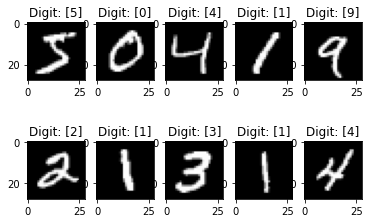

In [5]:
X = open('data/MNIST/train-images-idx3-ubyte','r')
Y = open('data/MNIST/train-labels-idx1-ubyte','r')

X_train = np.fromfile(X, dtype=np.uint8)
X_train = X_train[16:]
X_train = X_train.reshape((60000,28,28,1))

Y_train = np.fromfile(Y, dtype=np.uint8)
Y_train = Y_train[8:]
Y_train = Y_train.reshape((60000,1))


# preprocessing
X_train = X_train / 255


# plot first 10 images
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title("Digit: {}".format(Y_train[i]))






In [6]:
myNet = CNN()
myNet.create_network('data/archi.txt')
myNet.train(X_train,Y_train,0.01,5)

# test  
X_test = open('data/MNIST/t10k-images-idx3-ubyte','r')
Y_test = open('data/MNIST/t10k-labels-idx1-ubyte','r')

# test data
X_test = np.fromfile(X_test, dtype=np.uint8)
X_test = X_test[16:]
X_test = X_test.reshape((10000,28,28,1))

# test labels
Y_test = np.fromfile(Y_test, dtype=np.uint8)
Y_test = Y_test[8:]
Y_test = Y_test.reshape((10000,1))

# preprocessing
X_test = X_test / 255

# test

y_hat = myNet.forward(X_test)

# sk learn validation loss, accuracy and macro f1 score
from sklearn.metrics import accuracy_score, f1_score, precision_score

# accuracy
print('Accuracy: ',accuracy_score(Y_test,y_hat))

# precision
print('Precision: ',precision_score(Y_test,y_hat,average='macro'))

# f1 score
print('F1 score: ',f1_score(Y_test,y_hat,average='macro'))



Layer 	 Type 		 Parameters
1 	 Conv 		 6 5 1 2
2 	 ReLU
3 	 Pool 		 2 2
4 	 Conv 		 12 5 1 0
5 	 ReLU
6 	 Pool 		 2 2
7 	 Conv 		 100 5 1 0
8 	 ReLU
9 	 FC 		 10
10 	 Softmax


KeyboardInterrupt: 

### CIFAR-10

In [7]:
# load cifar10

# first batch

batch1 = open('data/CIFAR-10/data_batch_1','rb')

# unpickle
dict1 = pickle.load(batch1,encoding='bytes')

# reshape
X_train = np.reshape(dict1[b'data'],(10000,32,32,3))
Y_train = np.reshape(dict1[b'labels'],(10000,1))




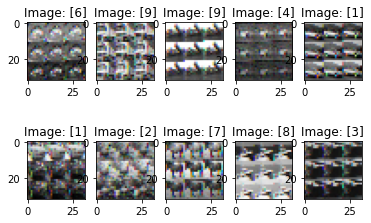

In [8]:
# plot first 10 images
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(32,32,3), cmap='gray')
    plt.title("Image: {}".format(Y_train[i]))

